In [185]:
# bibliotecas
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import numpy as np
import seaborn as sns

from ydata_profiling import ProfileReport

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import DistanceMetric, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import euclidean as scipy_euclidean

from tqdm.notebook import tqdm

import warnings
warnings.simplefilter("ignore")

sns.set_context("talk")

# Escolha de base de dados

## A. Fonte de dados
Dados sócio-econômicos e de saúde que determinam o índice de desenvolvimento de um país disponibilizado na plataforma Kaggle.

link: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data

In [186]:
paises = pd.read_csv("Country-data.csv")

# uma copia do dados para manipular
df_paises = paises.copy()

if (df_paises.index.name != "country"):
    df_paises.set_index(keys="country", inplace=True)

In [187]:
# informações sobre dados
print(paises.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


> Numero de paises

In [188]:
# numero de paises
print(f"\n >>> Possui {paises['country'].nunique()} paises na base. <<<")


 >>> Possui 167 paises na base. <<<


> Gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização.

> Note que as variáveis income e gdpp possuem escalar muito maiores que outras variáveis. Por isso, vamos aplicar StandardScaler para normalizar a base. Mas antes, vamos verificar se a base possui algum N/A

In [189]:
# inicialmente vamos verificar se há algum N/A
result = df_paises.isna().sum()
# print(result)

if (result.sum() == 0):
    print(f"Não há N/A na bases. Aplicando 'StandardScaler'")

    scaler = StandardScaler()

    paises_scaled = scaler.fit_transform(df_paises)

    paises_scaled = pd.DataFrame(paises_scaled, 
                             columns=df_paises.columns,
                             index=df_paises.index)
else:
    print(f"Existe N/A na base e deve ser tratados")

Não há N/A na bases. Aplicando 'StandardScaler'


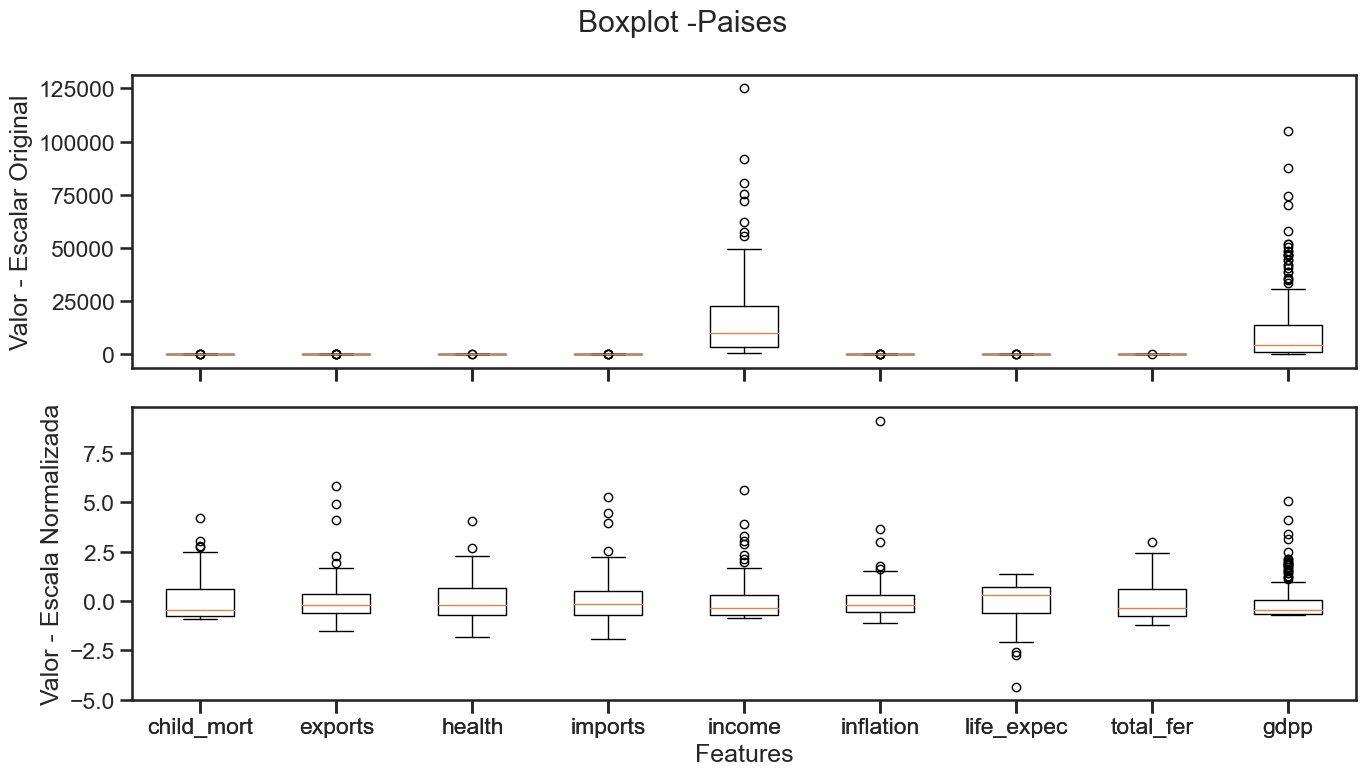

In [190]:
fig, axes = plt.subplots(nrows = 2, 
                         ncols = 1, 
                         figsize = (14, 8),
                         sharex=True)

fig.suptitle("Boxplot -Paises")
stats = cbook.boxplot_stats(df_paises, labels=df_paises.columns)
stats_scaled = cbook.boxplot_stats(paises_scaled, labels=paises_scaled.columns)

axes[0].bxp(stats)

# axes[0].set_xlabel("Features")
axes[0].set_ylabel("Valor - Escalar Original")

axes[1].bxp(stats_scaled)

axes[1].set_xlabel("Features")

axes[1].set_ylabel("Valor - Escala Normalizada")

fig.tight_layout()

# df_paises.plot(kind="box", figsize=(14, 5))
# paises_scaled.plot(kind="box", figsize=(14, 5))

> Note que as escalas das variáveis ficaram proximas.

# Clusterização

> Antes de realização a clusterização, vamos tentar entender a base. Principalmente as relações entre as variáveis.

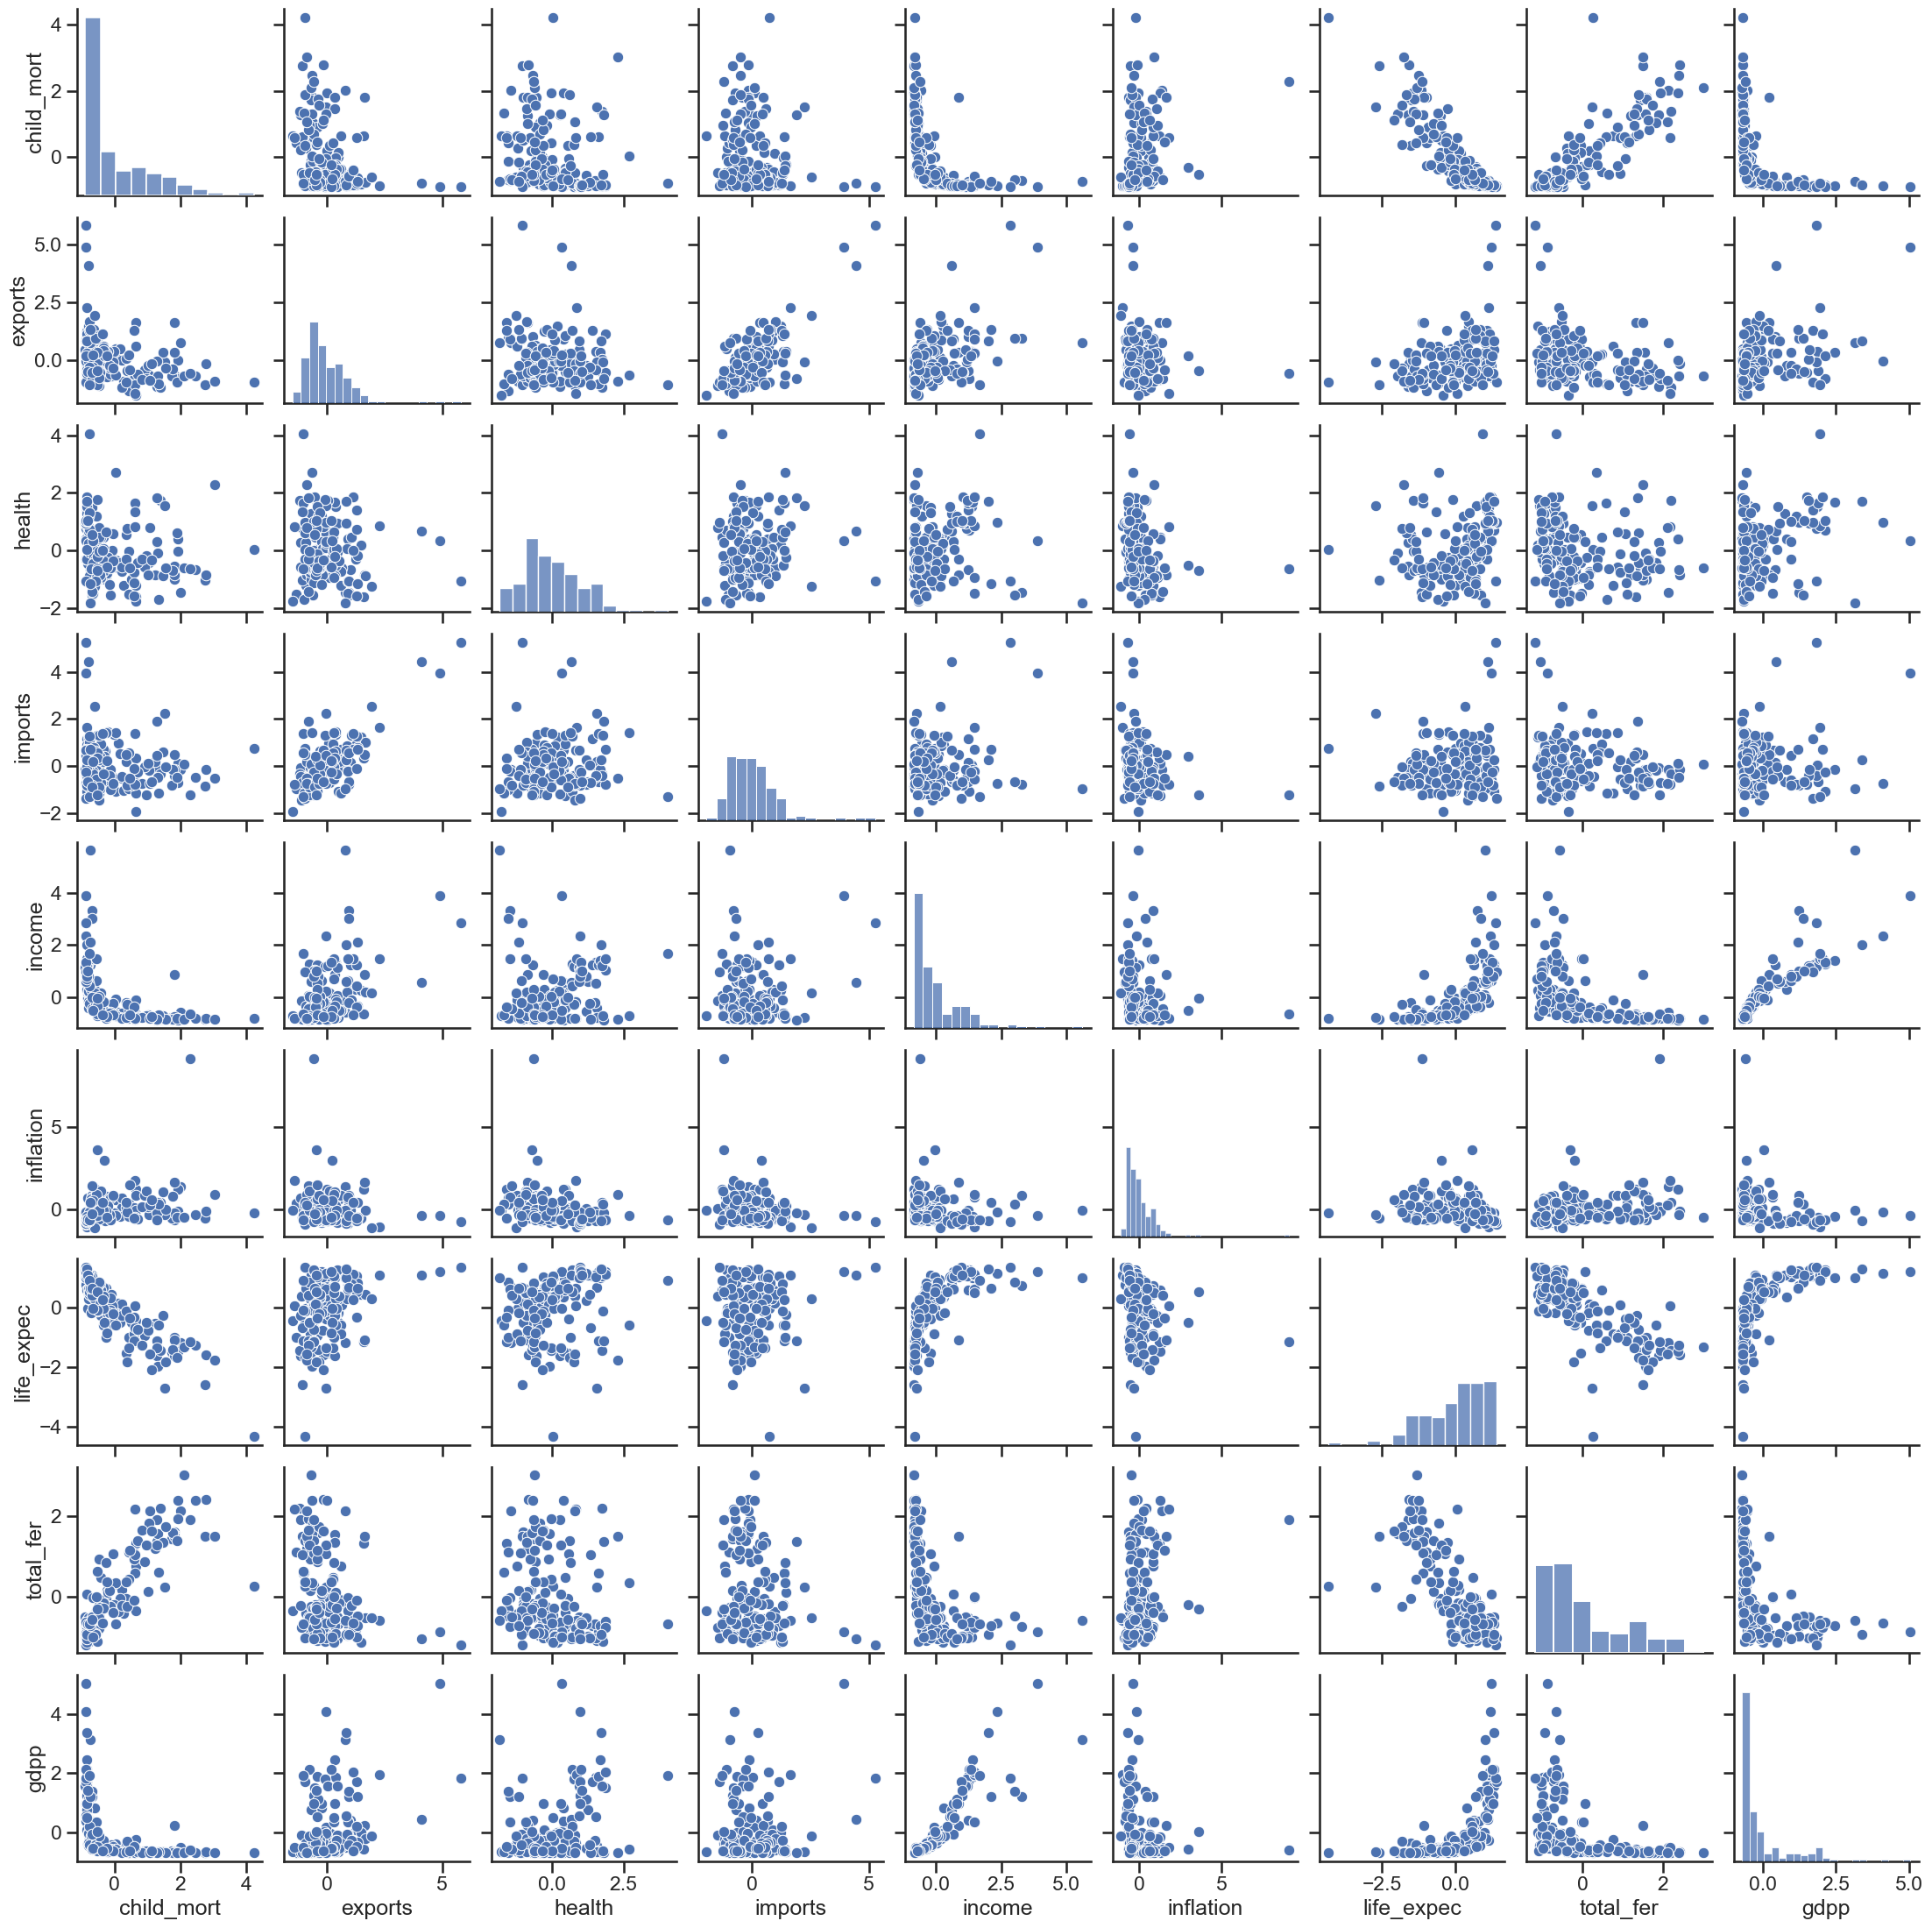

In [191]:
sns.pairplot(data=paises_scaled)
# pd.plotting.scatter_matrix(paises_scaled, 
#                           diagonal="kde",
#                           figsize = (15, 15))

In [192]:
# usando distancemetrics
euclidean = DistanceMetric.get_metric("euclidean")

distances = euclidean.pairwise(paises_scaled)
distances = pd.DataFrame(distances,
                         index=paises_scaled.index,
                         columns=paises_scaled.index)
# distances

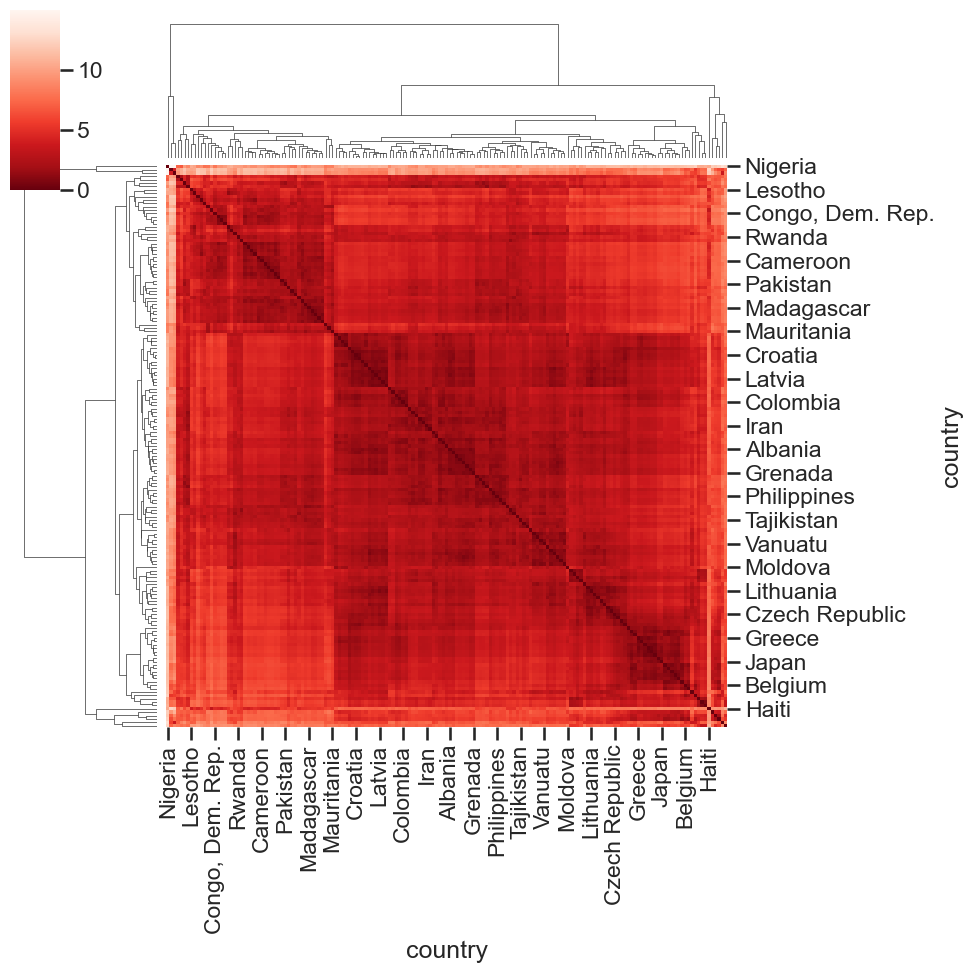

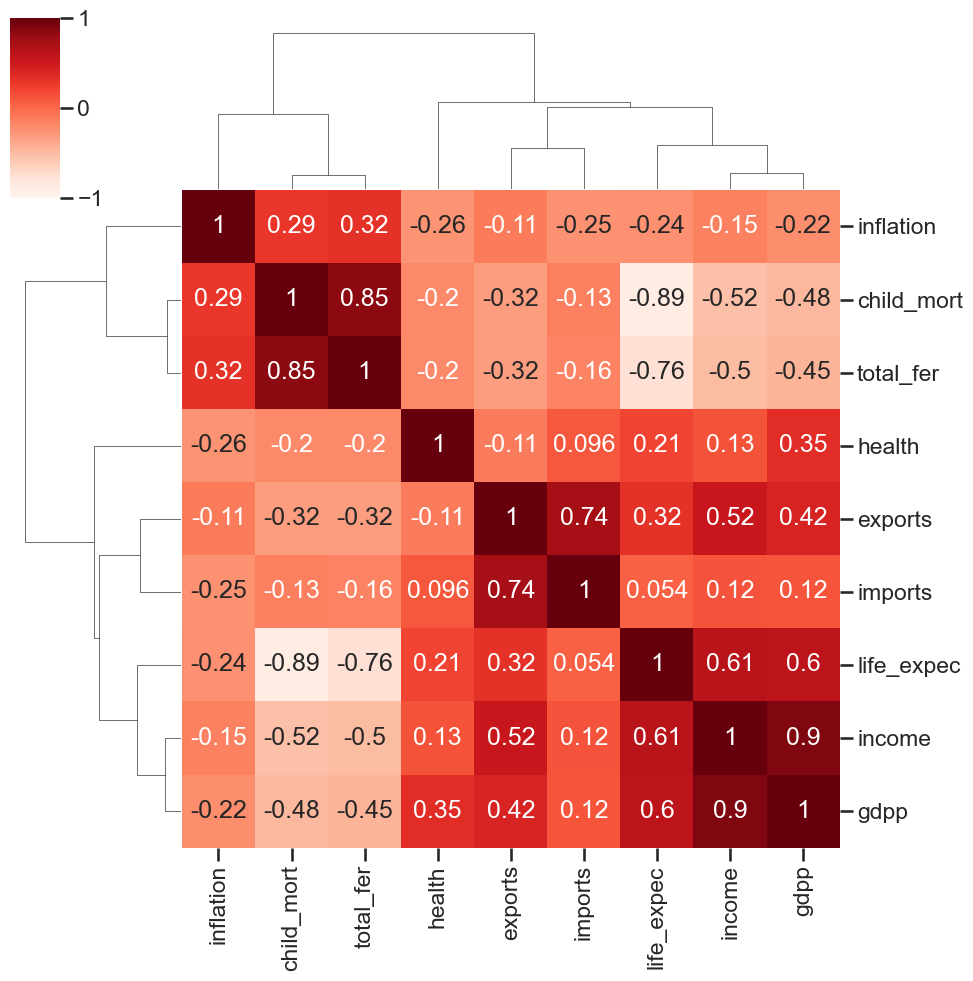

In [193]:
sns.clustermap(data = distances,
    cmap="Reds_r",
    vmin = 0,
    figsize = (10, 10))

sns.clustermap(data = paises_scaled.corr(), 
    cmap='Reds', 
    annot=True, 
    vmax=1, 
    vmin=-1,
    figsize = (10, 10))

### Realizando o agrupamento dos países em 3 grupos distintos

> usando K-Médias

In [194]:
# K-Means
n_cluster = 3
n_init = 100

kmeans = KMeans(
    n_clusters = n_cluster,
    init = "random",
    n_init = n_init,
    max_iter= 1000
)

kmeans.fit(paises_scaled)

clusters_kmeans = kmeans.predict(paises_scaled)

results_kmeans = paises_scaled.copy()
results_kmeans["clusters_kmeans"] = clusters_kmeans

> Clusterização Hierarquica

Text(0, 0.5, 'Distancia')

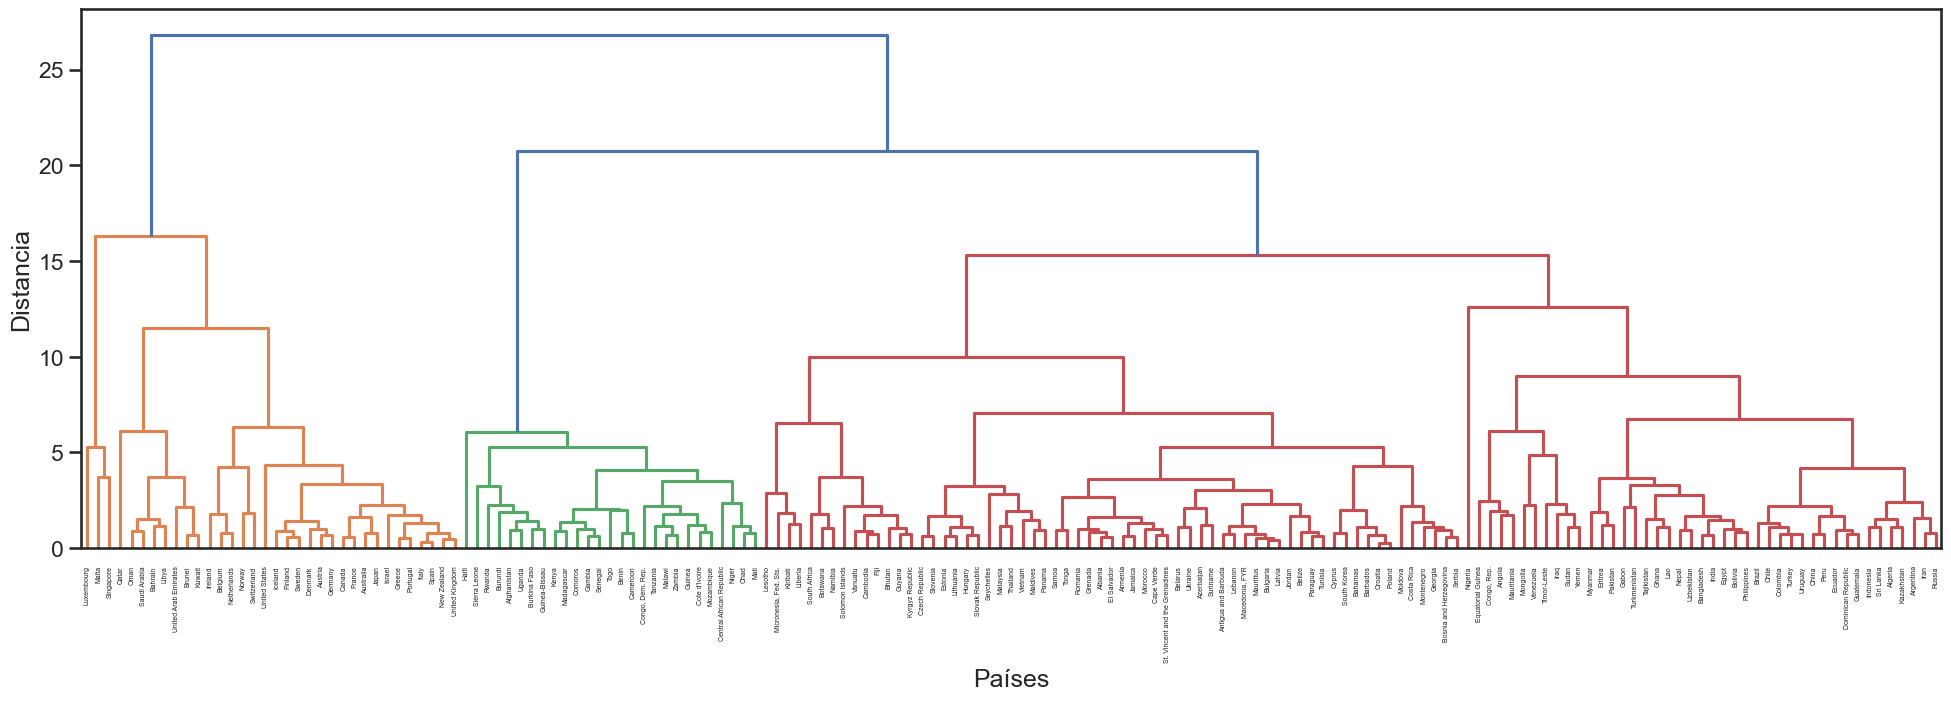

In [195]:
# clusterização hierarquica
plt.figure(figsize=(24, 7))

plt.grid(False)

linkage = sch.linkage(paises_scaled, method='ward')

# color_threshold = 20 gera 3 clusters
dendrogram = sch.dendrogram(linkage, color_threshold=20, labels=paises_scaled.index)

plt.xlabel("Países")

plt.ylabel("Distancia")

O resultado do Clusterização Hierarquica indica que dependendo da distancia escolhida, pode se chegar a vários agurpamentos diferentes.
Com o "color_threshold" entre 17 e 20 chega-se a 3 clusters (agrupamentos).

In [196]:
cluster_dend = pd.DataFrame(
  list(zip(dendrogram['leaves'], dendrogram['leaves_color_list'])),
  columns=["index", "cluster"],
  index=dendrogram["ivl"]
)

results_dend = paises_scaled.copy()

aux = cluster_dend.sort_index()
results_dend["clusters_dend"] = aux["cluster"]
print(results_dend.tail())

           child_mort   exports    health   imports    income  inflation  \
country                                                                    
Vanuatu     -0.225578  0.200917 -0.571711  0.240700 -0.738527  -0.489784   
Venezuela   -0.526514 -0.461363 -0.695862 -1.213499 -0.033542   3.616865   
Vietnam     -0.372315  1.130305  0.008877  1.380030 -0.658404   0.409732   
Yemen        0.448417 -0.406478 -0.597272 -0.517472 -0.658924   1.500916   
Zambia       1.114951 -0.150348 -0.338015 -0.662477 -0.721358   0.590015   

           life_expec  total_fer      gdpp clusters_dend  
country                                                   
Vanuatu     -0.852161   0.365754 -0.546913            C3  
Venezuela    0.546361  -0.316678  0.029323            C3  
Vietnam      0.286958  -0.661206 -0.637754            C3  
Yemen       -0.344633   1.140944 -0.637754            C3  
Zambia      -2.092785   1.624609 -0.629546            C2  


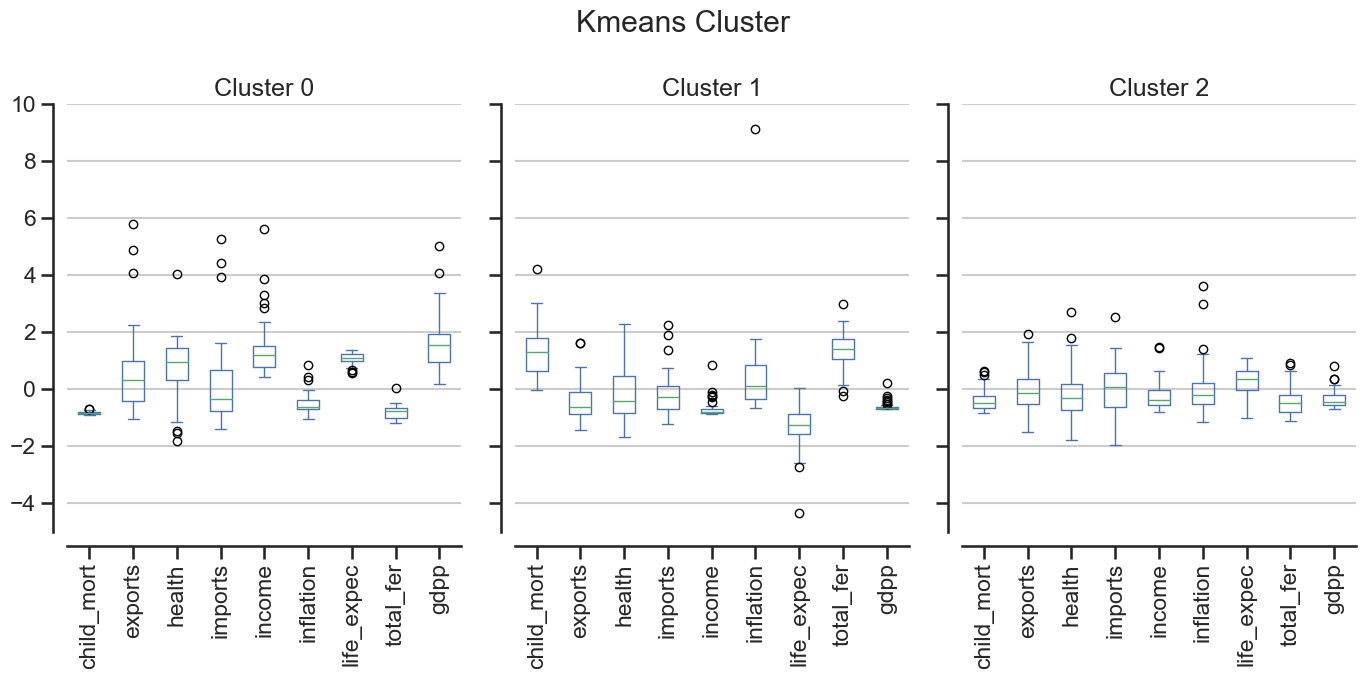

In [197]:
fig, axis = plt.subplots(nrows = 1, 
                         ncols = n_cluster, 
                         figsize=(14, 7), 
                         sharey = True)

fig.suptitle("Kmeans Cluster")

sns.set_style('ticks')

for idx in range(3):
    results_kmeans[results_kmeans.clusters_kmeans == idx].drop(['clusters_kmeans'], axis = 1).plot(kind="box", ax=axis[idx])
    axis[idx].set_title(f"Cluster {idx}")
    axis[idx].yaxis.grid(True)
    axis[idx].set_ylim([-5, 10])
    axis[idx].tick_params(axis = 'x', labelrotation = 90)
    sns.despine(offset=10)

fig.tight_layout()

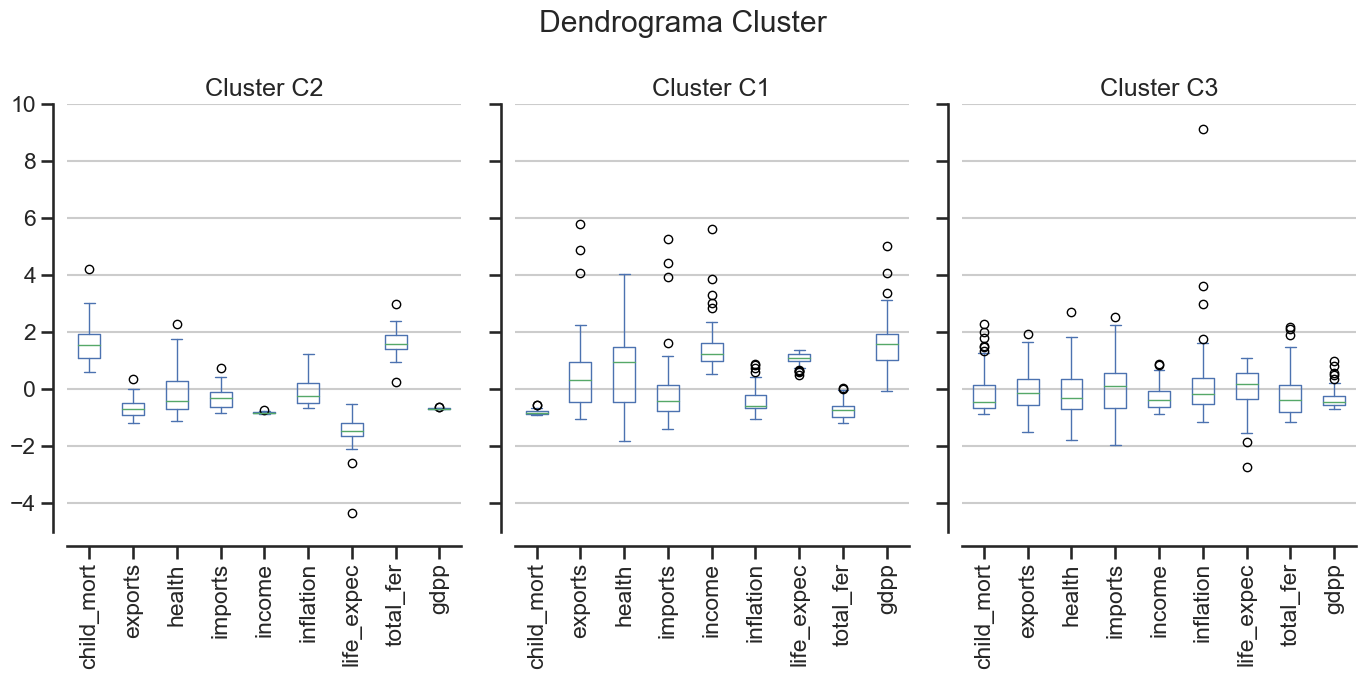

In [198]:
fig, axis = plt.subplots(nrows = 1, 
                         ncols = n_cluster, 
                         figsize=(14, 7), 
                         sharey = True)

fig.suptitle("Dendrograma Cluster")

clusters_set = set(results_dend["clusters_dend"])

sns.set_style('ticks')

i = 0

for idx in clusters_set:
    results_dend[results_dend.clusters_dend == idx].plot(kind="box", ax=axis[i])
    axis[i].set_title(f"Cluster {idx}")
    axis[i].yaxis.grid(True)
    axis[i].set_ylim([-5, 10])
    axis[i].tick_params(axis = 'x', labelrotation = 90)
    sns.despine(offset=10)
    i = i + 1

fig.tight_layout()

> As relações de clusters entre Kmeans e Dendo

Cluster 0 <-> Cluster C2

Cluster 1 <-> Cluster C3

Cluster 2 <-> Cluster C1

In [199]:
iKmeans = [0, 1, 2]
iDend = ['C2','C3', 'C1']

for i in range(len(iKmeans)):
    print(f"<<Clusters : Agrupamento KMeans {iKmeans[i]} <-> Hierarquica {iDend[i]} >>") 

    print(f"Paises em comum:\n{set(results_kmeans[results_kmeans.clusters_kmeans == iKmeans[i]].index) & set(results_dend[results_dend.clusters_dend == iDend[i]].index)}")
    
    print(f"Paises em KMeans mas não no Hierarquica:\n {set(results_kmeans[results_kmeans.clusters_kmeans == iKmeans[i]].index) - set(results_dend[results_dend.clusters_dend == iDend[i]].index)}\n")

<<Clusters : Agrupamento KMeans 0 <-> Hierarquica C2 >>
Paises em comum:
set()
Paises em KMeans mas não no Hierarquica:
 {'Australia', 'United Kingdom', 'United Arab Emirates', 'Sweden', 'Brunei', 'Finland', 'Spain', 'Germany', 'Austria', 'Portugal', 'Belgium', 'Iceland', 'Switzerland', 'New Zealand', 'Denmark', 'Japan', 'Slovak Republic', 'Canada', 'Israel', 'Singapore', 'United States', 'Czech Republic', 'Kuwait', 'Malta', 'France', 'Ireland', 'Norway', 'Qatar', 'Slovenia', 'South Korea', 'Bahrain', 'Greece', 'Italy', 'Cyprus', 'Luxembourg', 'Netherlands'}

<<Clusters : Agrupamento KMeans 1 <-> Hierarquica C3 >>
Paises em comum:
{'Yemen', 'South Africa', 'Iraq', 'Eritrea', 'Congo, Rep.', 'Gabon', 'Nigeria', 'Ghana', 'Kiribati', 'Equatorial Guinea', 'Angola', 'Lao', 'Lesotho', 'Namibia', 'Liberia', 'Mauritania', 'Timor-Leste', 'Sudan', 'Botswana', 'Pakistan'}
Paises em KMeans mas não no Hierarquica:
 {'Uganda', 'Haiti', 'Niger', 'Senegal', 'Mozambique', 'Afghanistan', 'Burkina Faso', 

Quando compara os dois resultados, conseguimos observar que cada cluster possui distribuição muito semelhantes. Entretanto, alguns países pertencem aos grupos diferentes. Isso é devido a metodos utilizados. Enquanto KMeans, o agrupamento é realizado a proximidade com centroides de cada pais, na Clusterização hierárquica a construção é feita primeiro entre os países mais proximos e segue agregando outros países que estão proximos aos conjuntos de paises do passo anterior e vai ampliando o agrupamento.

>Interpretação do resultado do KMeans

In [249]:
print("KMeans - Dimensão do cada grupo")

for i in range(len(iKmeans)):
    print(f"<<Clusters : {iKmeans[i]}>>") 

    print(f"Dimensão:\n{results_kmeans[results_kmeans.clusters_kmeans == iKmeans[i]].drop(['clusters_kmeans'], axis = 1).shape}\n")

KMeans - Dimensão do cada grupo
<<Clusters : 0>>
Dimensão:
(36, 9)

<<Clusters : 1>>
Dimensão:
(47, 9)

<<Clusters : 2>>
Dimensão:
(84, 9)



In [248]:
print("Hierarquica - Dimensão do cada grupo")

for i in range(len(iDend)):
    print(f"<<Clusters : {iDend[i]}>>") 

    print(f"Dimensão:\n{results_dend[results_dend.clusters_dend == iDend[i]].drop(['clusters_dend'], axis = 1).shape}\n")

Hierarquica - Dimensão do cada grupo
<<Clusters : C2>>
Dimensão:
(27, 9)

<<Clusters : C3>>
Dimensão:
(106, 9)

<<Clusters : C1>>
Dimensão:
(34, 9)



In [201]:
def get_distance(features):
    return scipy_euclidean(cluster, features)

for idx in range(n_cluster):
    cluster = kmeans.cluster_centers_[idx, :]
    cluster_paises = results_kmeans[results_kmeans.clusters_kmeans == idx].drop(['clusters_kmeans'], axis = 1)
    distances = cluster_paises.apply(get_distance, axis=1)
    closest_idx = distances.argmin()
    print(f"O pais mais representativo do cluster {idx} é o {distances.index[closest_idx]} ({distances[closest_idx]:.2f})")
    

O pais mais representativo do cluster 0 é o Iceland (0.73)
O pais mais representativo do cluster 1 é o Guinea (0.83)
O pais mais representativo do cluster 2 é o Jamaica (0.73)


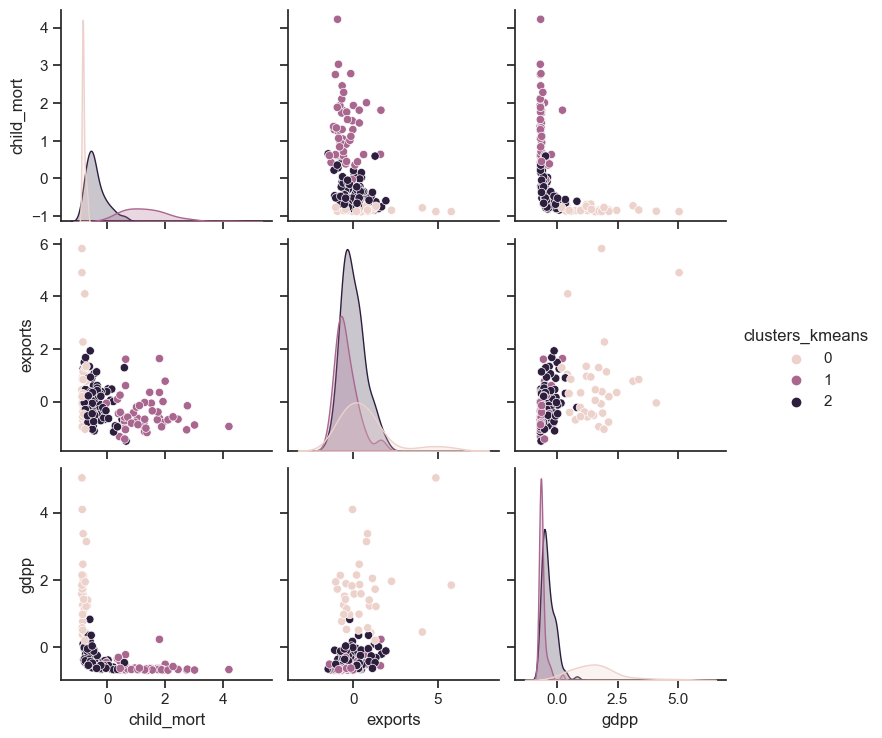

In [202]:
# Pairplot com resultado KMeans
sns.set_theme(style="ticks")

sns.pairplot(results_kmeans.drop(columns=['life_expec', 'health', 'imports', 'income', 'inflation', 'total_fer']), 
             hue="clusters_kmeans")

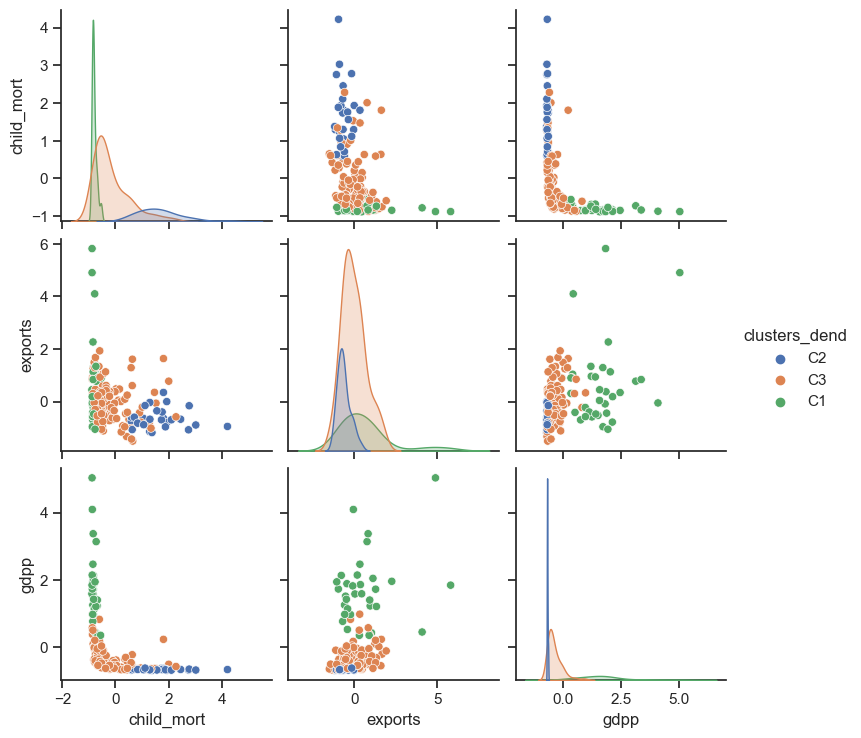

In [203]:
# Pairplot com resultado Classificação Hierarquica
sns.set_theme(style="ticks")

sns.pairplot(results_dend.drop(columns=['life_expec', 'health', 'imports', 'income', 'inflation', 'total_fer']), 
             hue="clusters_dend")

# Escolha de algoritmos

  0%|          | 0/8 [00:00<?, ?it/s]

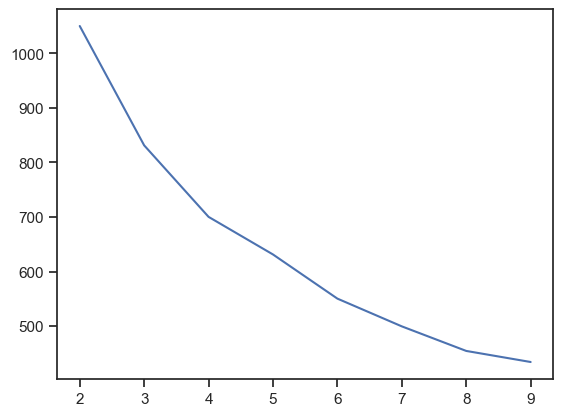

In [204]:
# K-Means
min_clusters = 2
max_clusters = 10
n_init = 100

errors = []

for n_cluster in tqdm(range(min_clusters, max_clusters)):
    kmeans = KMeans(
        n_clusters = n_cluster,
        init = "random",
        n_init = n_init,
        max_iter= 1000
    )

    result = kmeans.fit(paises_scaled)
    errors.append((n_cluster, result.inertia_))

clusters, inertia = zip(*errors)
plt.plot(clusters, inertia)

In [205]:
paises_features_representativo = results.copy()

sns.set_theme(style="ticks")

sns.pairplot(paises_features_representativo, hue="cluster")

NameError: name 'results' is not defined

# Simulacao KMean

>Algoritmo KMean inicial

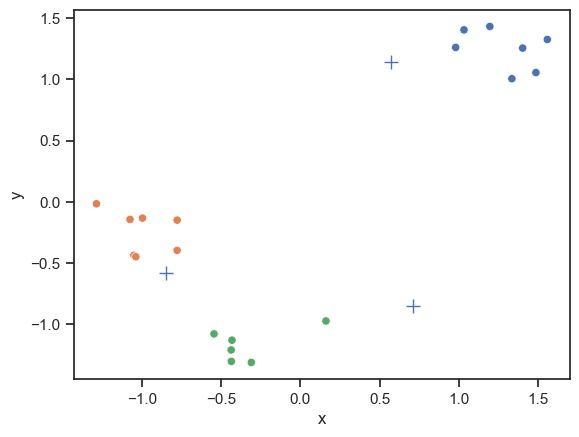

[[ 0.57247618  1.14413485]
 [ 0.70826742 -0.85425702]
 [-0.84981496 -0.58054434]]


In [236]:
from numpy.random import uniform
from sklearn.datasets import make_blobs
import random

centers = 3

x_data, y_data = make_blobs(n_samples=20, centers=centers, random_state=1)

x_data = StandardScaler().fit_transform(x_data)

centroids = [(random.uniform(min(x_data[:,0]), max(x_data[:,0])),
              random.uniform(min(x_data[:,1]), max(x_data[:,1])))
              for i in range(centers)]

centroids = np.array(centroids)

sns.scatterplot(x = x_data[:, 0],
                y = x_data[:, 1],
                hue = y_data,
                palette = "deep",
                legend = None)

plt.plot(centroids[:, 0],
        centroids[:, 1],
        "+",
        markersize = 10)

plt.xlabel("x")

plt.ylabel("y")

plt.show()

print(centroids)

>Convergencia do algoritmo de Kmeans

[[ 0.36272246  0.59822289]
 [-1.17983228 -0.08052831]
 [-0.33216749 -1.169603  ]]


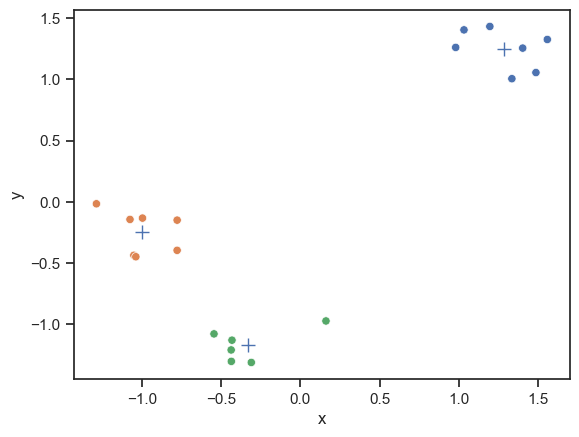

[[ 1.28400031  1.24957172]
 [-0.99928532 -0.24705486]
 [-0.33216749 -1.169603  ]]


In [241]:
# rodando varias vezes o algorithmo abaixo, há uma convergencia do algoritmo de Kmeans
distances = euclidean_distances(x_data, centroids)

labels = np.argmin(distances, axis = 1)

print(centroids)

centroids = pd.DataFrame(np.concatenate([x_data, labels.reshape(-1, 1)], axis=1)).groupby(2).mean().values

sns.scatterplot(x = x_data[:, 0],
                y = x_data[:, 1],
                hue = y_data,
                palette = "deep",
                legend = None)


plt.plot(centroids[:, 0],
        centroids[:, 1],
        "+",
        markersize = 10)

plt.xlabel("x")

plt.ylabel("y")

plt.show()

print(centroids)

>Substituindo Centroides pelo Medoides

[[-0.43487224 -1.30510078]
 [ 1.03222934  1.40542362]
 [-0.43082274 -1.13179263]]


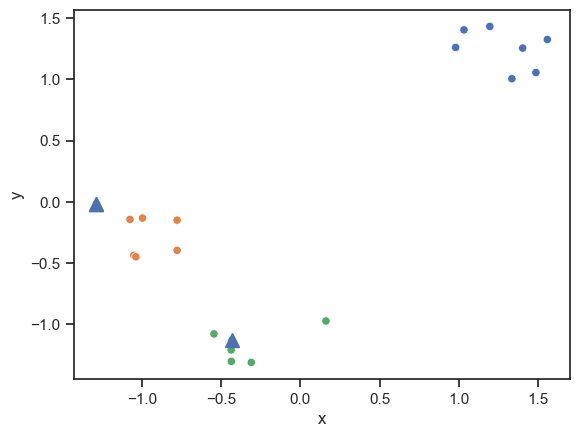

[[-0.43082274 -1.13179263]
 [-1.2856975  -0.0165825 ]
 [-1.2856975  -0.0165825 ]]


In [244]:
def get_distance(features):
    return scipy_euclidean(cluster, features)

print(centroids)
# rodando algoritmo KMeans com Medoides
distances = euclidean_distances(x_data, centroids)

labels = np.argmin(distances, axis = 1)

datas = pd.DataFrame(np.concatenate([x_data, labels.reshape(-1, 1)], axis=1))

centroids = datas.groupby(2).mean().values

for idx in range(centers):
    cluster = centroids[idx, :]
    cluster_x = datas[datas[2] == idx].drop(columns=2, axis = 1)
    distances = cluster_x.apply(get_distance, axis=1)
    closest_idx = distances.argmin()
    # substituindo pelo medoide
    centroids[idx, :] = np.array(datas[datas.index == closest_idx].drop(columns=2, axis = 1))[0]

sns.scatterplot(x = x_data[:, 0],
                y = x_data[:, 1],
                hue = y_data,
                palette = "deep",
                legend = None)


plt.plot(centroids[:, 0],
        centroids[:, 1],
        "^",
        markersize = 10)

plt.xlabel("x")

plt.ylabel("y")

plt.show()

print(centroids)
